Resnet

In [1]:
import numpy as np
import pandas as pd
import pydicom as dicom
import os
import matplotlib.pyplot as plt
import cv2
import math
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam

In [ ]:
DATA_DIR = 'Data/'
LABELS_CSV = 'LungCT-Labels - Sheet1.csv' 
IMG_SIZE_PX = 150
SLICE_COUNT = 20

In [ ]:
# 3D ResNet block
def resnet_block(input_layer, filters):
    x = layers.Conv3D(filters, kernel_size=3, padding='same', activation='relu')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Residual connection
    shortcut = layers.Conv3D(filters, kernel_size=1, padding='same')(input_layer)
    x = layers.add([x, shortcut])
    return layers.Activation('relu')(x)

In [4]:
# Function to build the ResNet model
def build_resnet(input_shape=(SLICE_COUNT, IMG_SIZE_PX, IMG_SIZE_PX, 1), num_classes=2):
    inputs = Input(shape=input_shape)
    
    # Initial Convolution + Pooling
    x = layers.Conv3D(32, kernel_size=7, strides=2, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling3D(pool_size=3, strides=2, padding='same')(x)
    
    # Residual Blocks
    for filters in [32, 64, 128, 256]:
        x = resnet_block(x, filters)
    
    # Global Average Pooling and Dense Layer
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

In [5]:
# Function to load and preprocess data
def load_data(data_dir, labels_df, img_size_px=IMG_SIZE_PX, hm_slices=SLICE_COUNT):
    image_full_data = []
    
    patients = os.listdir(data_dir)

    for patient in patients:
        label = labels_df.at[patient, 'Labels']
        path = os.path.join(data_dir, patient)
        slices = [dicom.read_file(os.path.join(path, s)) for s in os.listdir(path)]
        slices.sort(key=lambda x: int(x.ImagePositionPatient[2]))

        new_slices = []
        slices = [cv2.resize(np.array(each_slice.pixel_array), (img_size_px, img_size_px)) for each_slice in slices]
        
        chunk_sizes = math.ceil(len(slices) / hm_slices)
        for i in range(0, len(slices), chunk_sizes):
            slice_chunk = slices[i:i + chunk_sizes]
            if len(slice_chunk) > 0:
                new_slices.append(np.mean(slice_chunk, axis=0))

        if len(new_slices) < hm_slices:
            last_slice = new_slices[-1]
            while len(new_slices) < hm_slices:
                new_slices.append(last_slice)

        image_full_data.append([new_slices, np.array([1, 0]) if label == 1 else np.array([0, 1])])

    return image_full_data

In [6]:

# Load labels
labels_df = pd.read_csv(LABELS_CSV, index_col=0)

# Load and preprocess data
image_full_data = load_data(DATA_DIR, labels_df)

In [7]:
# Shuffle and split data into training and validation sets
np.random.shuffle(image_full_data)
train_data = image_full_data[:int(len(image_full_data) * 0.8)]
validation_data = image_full_data[int(len(image_full_data) * 0.8):]

train_X = np.array([data[0] for data in train_data])
train_Y = np.array([data[1] for data in train_data])
valid_X = np.array([data[0] for data in validation_data])
valid_Y = np.array([data[1] for data in validation_data])


In [8]:
# Reshape data for model input
train_X = train_X.reshape((-1, SLICE_COUNT, IMG_SIZE_PX, IMG_SIZE_PX, 1))
valid_X = valid_X.reshape((-1, SLICE_COUNT, IMG_SIZE_PX, IMG_SIZE_PX, 1))


In [9]:
# Build the ResNet model
model = build_resnet(input_shape=(SLICE_COUNT, IMG_SIZE_PX, IMG_SIZE_PX, 1))


In [10]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
# Summary of the model
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 20, 150,   │          0 │ -                 │
│ (InputLayer)        │ 150, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 10, 75,    │     11,008 │ input_layer[0][0] │
│                     │ 75, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 5, 38, 38, │          0 │ conv3d[0][0]      │
│ (MaxPooling3D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 5, 38, 38, │     27,680 │ max_pooling3d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 5, 38, 38, │        128 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 5, 38, 38, │     27,680 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 38, 38, │        128 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 5, 38, 38, │      1,056 │ max_pooling3d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 5, 38, 38, │          0 │ batch_normalizat… │
│                     │ 32)               │            │ conv3d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 5, 38, 38, │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 5, 38, 38, │     55,360 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 38, 38, │        256 │ conv3d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 5, 38, 38, │    110,656 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 38, 38, │        256 │ conv3d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 5, 38, 38, │      2,112 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 5, 38, 38, │          0 │ batch_normalizat… │
│                     │ 64)               │            │ conv3d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 5, 38, 38, │          0 │ add_1[0][0]     

 Total params: 3,731,874 (14.24 MB)

 Trainable params: 3,729,954 (14.23 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
# Fit the model and store training history
history = model.fit(train_X, train_Y, batch_size=5, epochs=100, validation_data=(valid_X, valid_Y))


Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 162s 14s/step - accuracy: 0.3519 - loss: 18.7402 - val_accuracy: 0.4615 - val_loss: 9.3808
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 132s 13s/step - accuracy: 0.4720 - loss: 17.8204 - val_accuracy: 0.4615 - val_loss: 9.2410
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 125s 13s/step - accuracy: 0.6705 - loss: 3.9613 - val_accuracy: 0.5385 - val_loss: 0.7333
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 118s 12s/step - accuracy: 0.4900 - loss: 11.8781 - val_accuracy: 0.4615 - val_loss: 6.7646
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 118s 12s/step - accuracy: 0.6040 - loss: 5.7133 - val_accuracy: 0.5385 - val_loss: 1.7851
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 100s 10s/step - accuracy: 0.4463 - loss: 3.6830 - val_accuracy: 0.5385 - val_loss: 4.5888
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 81s 8s/step - accuracy: 0.5332 - loss: 4.4935 - val_accuracy: 0.4615 - val_loss: 1.2171
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 79s 8s/step - accuracy: 0.5541 - loss: 7.2426 - val_accur

In [17]:
# Save the model
model.save("resnet_model.h5")

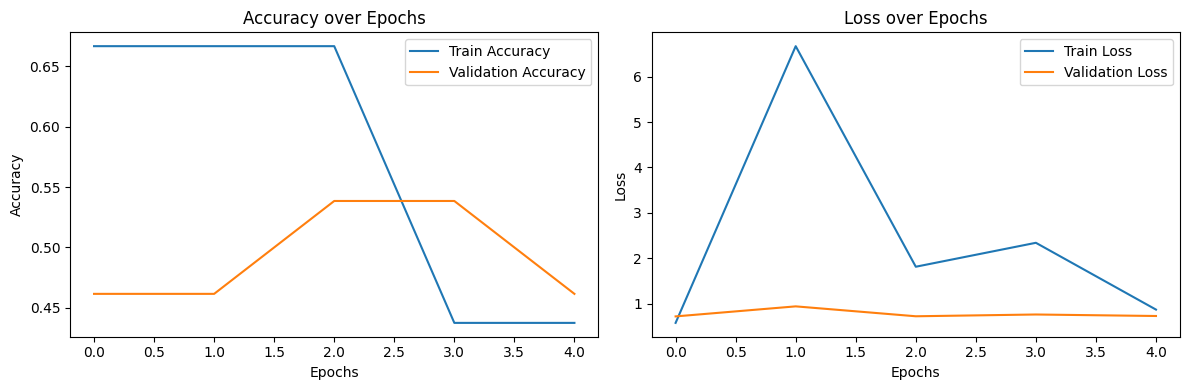

In [18]:
# Plotting the training and validation accuracy and loss
def plot_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_history(history)